PU comparison

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os, yaml
sys.path.append('../lib')
sys.path.append('../analysis')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar
from array import array

from analysis_utilities import drawOnCMSCanvas, getEff
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Events
from DataFormats.FWLite import Handle

In [3]:
from prettytable import PrettyTable

In [4]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [5]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
def extractEff(fn):
    with open(fn) as f:
        for l in f.readlines():
            if not l.startswith('Eff'): continue
            return [float(l.split(' ')[1]), float(l.split(' ')[3])]
    return [None, None]

In [8]:
def extractNacc(fn):
    with open(fn) as f:
        for l in f.readlines():
            if not l.startswith('N_accepted'): continue
            return int(l.split(' ')[1])
    return None

# B2DstMu

## Data

In [9]:
RDloc = '../data/cmsRD/skimmed/probeB2DstMu_200315.root'
lumiFile = '../data/cmsRD/lumiReport/ParkingBPH5_Run2018D-05May2019promptD-v1_RDntuplizer_probeB2DstMu_200315_bricalc.csv'

# Get the lumi
lines = open(lumiFile,'r').readlines()
l = lines[-3][:-1].split(',')[-1]
CMS_lumi.integrated_lumi = float(l)

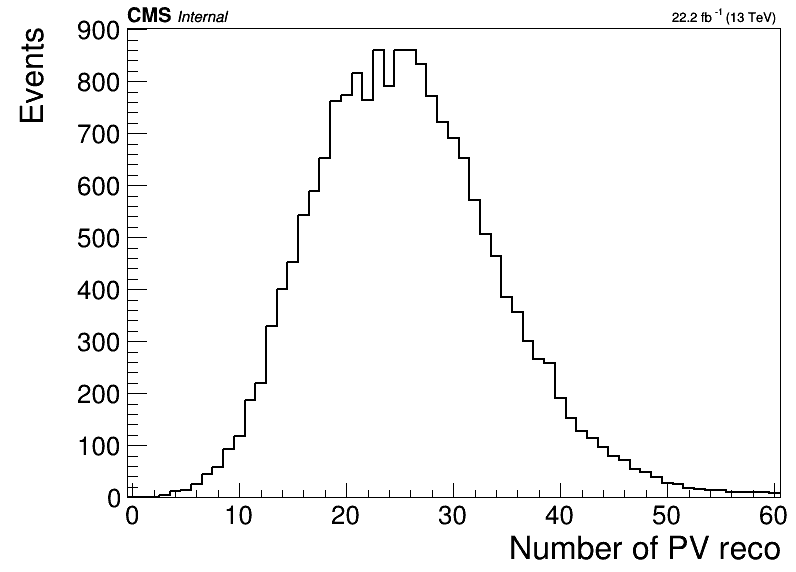

In [10]:
# Fill the histo
# colors = [rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]
t = ur.open(RDloc)['Tevts']
x = np.array(t.array('N_vtx'))
hO = create_TH1D(x, binning=[61, -0.5, 60.5], axis_title=['Number of PV reco', 'Events'])

c = drawOnCMSCanvas(CMS_lumi, [hO])

In [11]:
h = hO.Clone('h0')
dataNorm = h.Integral()
h.Scale(1./h.Integral())
h.SetLineWidth(2)
h.SetLineColor(1)

In [12]:
#Value got from down in the NB
pCoeffFromMC = [-0.00268836, 0.93244846]

def probLinMulti(n, pCoeff=pCoeffFromMC, lamVal=[20, 35], lamFrac=[0.5,0.5]):
    out = 0
    for lam, frac in zip(lamVal, lamFrac):
        x = np.exp(-lam)/factorial(n)
        s = 0
        lastV = 1
        N = float(n)
        while lastV > 1e-2*s or N < 15:
            p = np.polyval(pCoeff, N)
            lastV = np.power(p, n)*np.power(1-p,N-n)*np.power(lam, N)/factorial(N-n)
            s += lastV
            N += 1
        out += frac*x*s 

    return out

In [13]:
def chi2LinMulti(inputs, npCoeff, nComp):
#     pCoeff = inputs[:npCoeff]
    lamVal = inputs[npCoeff:npCoeff+nComp]
    lamFrac = inputs[npCoeff+nComp:]
    chi2 = 0
    for i in range(1, h.GetNbinsX()+1):
        if h.GetBinContent(i) < 5e-3: continue
        aux = h.GetBinContent(i) - probLinMulti(i-1, lamVal=lamVal, lamFrac=lamFrac) #, pCoeff=pCoeff)
        aux /= h.GetBinError(i)
        chi2 += aux**2
    return chi2

In [14]:
# pCoeff = [-2.0e-04,  1.0e-03,  9.3e-01]
# pCoeff = [-4e-3, 0.96]
pCoeff = []


lamVal = [14., 21., 30., 42., 50.]
lamFrac = [0.10, 0.35, 0.37, 0.13, 0.03]
npCoeff, nComp = len(pCoeff), len(lamVal)
x0 = pCoeff+lamVal+lamFrac
print 'Start chi2: {:.1f}'.format(chi2LinMulti(x0, len(pCoeff), len(lamVal)))
res = minimize(chi2LinMulti, x0, args=(len(pCoeff), len(lamVal)), tol=1e-5)
print 'End chi2: {:.1f} ({:.1f})'.format(res.fun, res.fun/h.GetNbinsX())

Start chi2: 1575.1
End chi2: 26.7 (0.4)


In [15]:
print 'Coeff:', res.x[:len(pCoeff)]
outPois = res.x[npCoeff:]
for i in range(nComp):
    print 'lam={:.2f}, frac={:.3f}'.format(outPois[i], outPois[i+nComp])
print 'Norm: {:.3f}'.format(np.sum(outPois[nComp:]))

Coeff: []
lam=14.67, frac=0.059
lam=22.06, frac=0.309
lam=32.06, frac=0.431
lam=42.47, frac=0.149
lam=51.09, frac=0.045
Norm: 0.992


In [16]:
ftest_list = glob('../data/cmsMC_private/BP_Probe_B0_MuNuDmst_Tag-B_MuNuDst_Hardbbbar_evtgen_ISGW2_PUc1_10-2-3/jobs_out/out_MINIAODSIM_*.root')
handle = {}
handle['vtx'] = [Handle('vector<reco::Vertex>'), 'offlineSlimmedPrimaryVertices']
N_vtx_MINIAOD = []
pb = ProgressBar(len(ftest_list))
for i_f, fn in enumerate(ftest_list):
    pb.show(i_f)
    for event in Events(fn):
        prods = {}
        for k,v in handle.iteritems():
            event.getByLabel(v[1], v[0])
            prods[k] = v[0].product()
        N_vtx_MINIAOD.append(prods['vtx'].size())
N_vtx_MINIAOD = np.array(N_vtx_MINIAOD)

[####################]  100% - Tot. time: 26.6 s


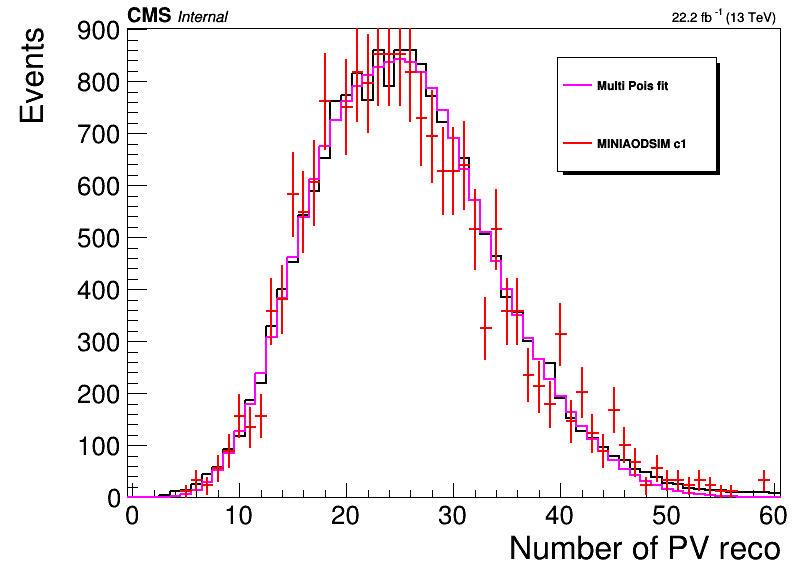

In [17]:
hFit = h.Clone('hFit')
hFit.Reset()
hFit.SetFillStyle(0)
hFit.SetLineColor(6)
hFit.SetLineStyle(1)
for i in range(1, hFit.GetNbinsX()+1):
    n = hFit.GetBinCenter(i)
    if npCoeff:
        pCoeff = res.x[:npCoeff]
    else: pCoeff = pCoeffFromMC
    lamVal = res.x[npCoeff:npCoeff+nComp]
    lamFrac = res.x[npCoeff+nComp:]
    hFit.SetBinContent(i, probLinMulti(n, pCoeff, lamVal, lamFrac))

hFit.Scale(dataNorm)
hSim = create_TH1D(N_vtx_MINIAOD, h2clone=hFit, scale_histo=dataNorm/float(N_vtx_MINIAOD.shape[0]))
hSim.SetLineColor(2)
# m = SetMaxToMaxHist(hlist+[hFit, hSim], 0.8)
c = drawOnCMSCanvas(CMS_lumi, [hO, hFit, hSim], 'same')
leg1 = rt.TLegend(0.7, 0.7, 0.9, 0.9)
leg1.AddEntry(hFit, 'Multi Pois fit', 'l')
leg1.AddEntry(hSim, 'MINIAODSIM c1', 'l')
leg1.Draw()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
0.00000, 0.00000, 0.00000, 0.00001, 0.00005, 0.00108, 0.00128, 0.00167, 0.00230, 0.00325, 0.00452, 0.00610, 0.00797, 0.01010, 0.01248, 0.01511, 0.01795, 0.02093, 0.02391, 0.02670, 0.02914, 0.03109, 0.03253, 0.03350, 0.03413, 0.03455, 0.03491, 0.03525, 0.03558, 0.03582, 0.03587, 0.03563, 0.03499, 0.03394, 0.03248, 0.03069, 0.02866, 0.02652, 0.02435, 0.02226, 0.02029, 0.01849, 0.01686, 0.01538, 0.01405, 0.01282, 0.01169, 0.01064, 0.00965, 0.00872, 0.00784, 0.00702, 0.00626, 0.00556, 0.00491, 0.00433, 0.00381, 0.00335, 0.00294, 0.00259, 0.00228, 0.00202, 0.00181, 0.00162, 0.00147, 0.00135, 0.00126, 0.00118, 0.00112, 0.00107, 0.00009, 0.00007, 0.00005, 0.00003, 0.00002, 0.00001, 0.000

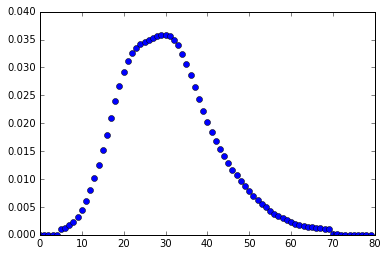

In [18]:
from scipy.stats import poisson
nVtx = []
prob = []
for n in range(80):
    if npCoeff:
        pCoeff = res.x[:npCoeff]
    else: pCoeff = pCoeffFromMC
    lamVal = res.x[npCoeff:npCoeff+nComp]
    lamFrac = res.x[npCoeff+nComp:]
    p = 0
    for lam, f in zip(lamVal, lamFrac):
        p += f*poisson.pmf(n, lam)
    prob.append(p)
    nVtx.append(n)

#Add some sort of flat pedestall to save the tails
prob = np.array(prob)
prob[5:70] += 1e-3
prob /= np.sum(prob)

plt.plot(nVtx, prob, 'o')
print nVtx
print ', '.join(['{:.5f}'.format(p) for p in prob])

In [19]:
npCoeff

0